## Train and Prediction on valid

Using rotated to hz + OpenCv border

Basic default transforms

Densenet

at bs=32 only using 1.8GB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from torchvision.models import densenet121

In [3]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [4]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [5]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [6]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [7]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [8]:
RETRAIN = True
RESIZE_IMAGES = True

In [9]:
MODEL_NAME='cv_reflect_101'

In [10]:
NB_NUM='06_13'

In [11]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 0a784698, DATE: 20191126


In [12]:
DATE = '20191126'
UID = 'f6831db3'

In [13]:
SUB_NUM='7'

In [14]:
img_size=256
bs=64

In [15]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [16]:
### add St Lucia pred cement as valid

In [17]:
df_all=pd.read_csv(data_dir/'df_all_repl_st_lucia_castries_gold_concrete_cement.csv')

In [18]:
df_all.drop(columns=['target'],inplace=True)

In [19]:
df_valid=df_all.loc[df_all['verified'] == True]

In [20]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [21]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [22]:
df_all.loc[df_all['id'] == '7a204ec4']

,country,id,region,roof_material,verified
12960,guatemala,7a204ec4,mixco_1_and_ebenezer,irregular_metal,True


In [23]:
len(df_all)

22539

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [24]:
xtra_tfms=[rand_crop(p=0.4)]
tfms = get_transforms(flip_vert=True, max_lighting=0.25, max_zoom=1.2, max_warp=0., xtra_tfms=xtra_tfms)

### setup dataset

In [25]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_valid, cols='id', suffix='.tif')
       .split_by_rand_pct(0.1)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

14945


In [26]:
data = (src.transform(tfms, size=256)
        .databunch(bs=bs).normalize(imagenet_stats))

In [27]:
#to check what params object has
#dir(data)

In [28]:
data.label_list

LabelLists;

Train: LabelList (13451 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (1494 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
healthy_metal,healthy_metal,concrete_cement,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [29]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

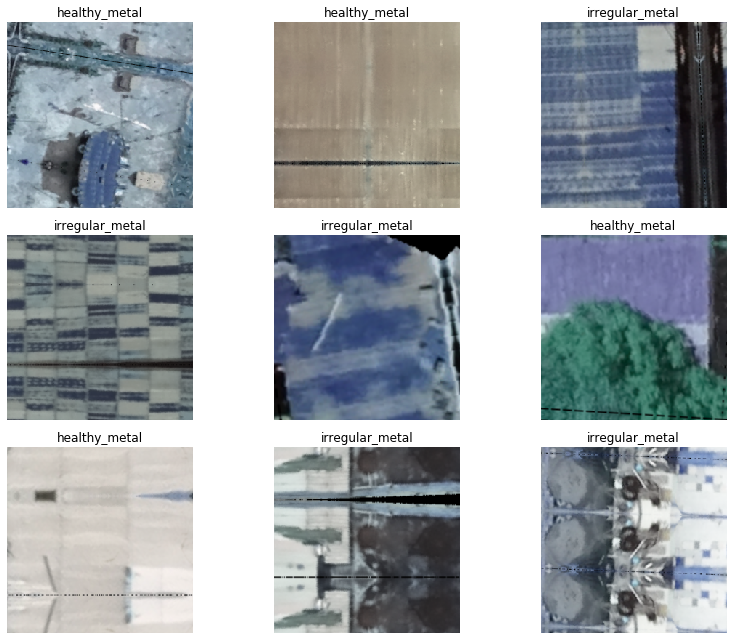

In [30]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [31]:
arch = models.densenet169
arch_name = 'dn169'

In [32]:
#FP16


In [33]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()
learn.loss_func = LabelSmoothingCrossEntropy(eps=0.01)

In [34]:
learn.loss_func

LabelSmoothingCrossEntropy()

In [35]:
#learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1, 2])

We use the LR Finder to pick a good learning rate.

In [36]:
save_name=f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}'
save_name

'stage-1-dn169-06_13-cv_reflect_101-20191126-f6831db3'

In [37]:
callbacks = [SaveModelCallback(learn, every='improvement', monitor='valid_loss', name=save_name)]


### Train model

In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


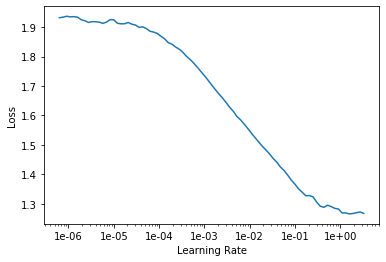

In [39]:
learn.recorder.plot()

Then we can fit the head of our network.

In [40]:
lr = 1e-3

In [41]:
learn.fit_one_cycle(25, slice(lr), callbacks=callbacks)

epoch,train_loss,valid_loss,error_rate,time
0,1.281556,1.192447,0.409639,01:28
1,1.106370,1.044258,0.301205,01:41
2,0.985520,0.936826,0.251673,01:38
3,0.901778,0.848525,0.237617,01:41
4,0.793578,0.747511,0.215529,01:39
5,0.703433,0.684819,0.208835,01:38
6,0.637983,0.645297,0.206827,01:38
7,0.599102,0.591643,0.194110,01:41
8,0.572667,0.564412,0.192102,01:36
9,0.537676,0.548693,0.195448,01:36


/mnt/963GB/Data/Python/Code/comps/driven_data/caribbean_disaster_risk/fastai/callbacks/tracker.py:50: UserWarning: <class 'fastai.callbacks.tracker.SaveModelCallback'> conditioned on metric `val_loss` which is not available. Available metrics are: train_loss, valid_loss, error_rate
  warn(f'{self.__class__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:-1]))}')


learn.fit_one_cycle(5, slice(lr),  callbacks=[
                        SaveModelCallbackVerbose(learn=learn,
                                                 monitor='error_rate',
                                                 mode='min',
                                                 name=f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')
])

In [42]:
save_name=f'stage-1-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}'

In [43]:
#learn.fit_one_cycle(20, slice(lr), callbacks=callbacks)

#### Load model

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 110),
 ('healthy_metal', 'irregular_metal', 82),
 ('incomplete', 'irregular_metal', 29),
 ('concrete_cement', 'healthy_metal', 16),
 ('concrete_cement', 'irregular_metal', 11),
 ('other', 'irregular_metal', 8),
 ('healthy_metal', 'concrete_cement', 7),
 ('incomplete', 'concrete_cement', 7),
 ('irregular_metal', 'concrete_cement', 7),
 ('irregular_metal', 'incomplete', 6),
 ('other', 'healthy_metal', 4),
 ('concrete_cement', 'incomplete', 3),
 ('incomplete', 'healthy_metal', 2)]

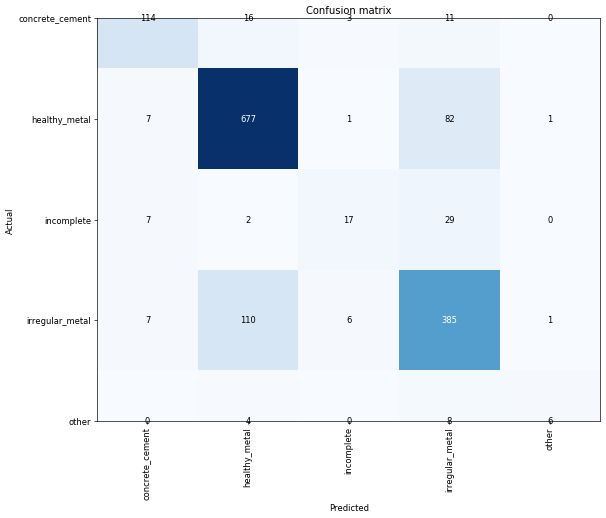

In [45]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [48]:
learn=learn.to_fp32()

In [49]:
learn.export()

### inference

In [50]:
test_dataset=ImageList.from_folder(test_images)

In [51]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [52]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [54]:
learn.loss_func = LabelSmoothingCrossEntropy(eps=0.01)

In [56]:
learn.loss_func

LabelSmoothingCrossEntropy()

In [57]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [58]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

Get number of items in the Valid dataset (in DeviceDataLoader)

In [59]:
len(learn.dl(DatasetType.Test).dl)

240

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [60]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [61]:
labels = np.argmax(preds, 1)

In [62]:
len(preds)

15325

In [63]:
preds[0].tolist()

[1.4626219272613525,
 4.1049323081970215,
 -1.3830149173736572,
 -2.415337324142456,
 -1.734609842300415]

In [64]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [65]:
len(labels)

15325

In [66]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [67]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [68]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [69]:
test_predictions[0]

'healthy_metal'

In [70]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [71]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a468774.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4b7946.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4e81f4.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a501f50.tif')], dtype=object)

In [72]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [73]:
preds_list[0]

[1.4626219272613525,
 4.1049323081970215,
 -1.3830149173736572,
 -2.415337324142456,
 -1.734609842300415]

In [74]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [75]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [76]:
df.head()

,id,pred
0,7a4d9168,"[1.4626219272613525, 4.1049323081970215, -1.38..."
1,7a4ae922,"[-1.08860445022583, 2.875328779220581, -2.4981..."
2,7a48ca98,"[-1.7646093368530273, 0.8826120495796204, -1.1..."
3,7a49c614,"[-2.0537912845611572, 2.220350503921509, -1.44..."
4,7a4dd4f2,"[-1.7966029644012451, 3.02917742729187, -1.952..."


In [77]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [78]:
pred_df.insert(loc=0, column='id', value=ids)

In [79]:
pred_df.columns = cols

In [80]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,1.462622,4.104932,-1.383015,-2.415337,-1.734610
1,7a4ae922,-1.088604,2.875329,-2.498139,-0.052946,-2.981256
2,7a48ca98,-1.764609,0.882612,-1.193232,2.356132,-2.384990
3,7a49c614,-2.053791,2.220351,-1.446068,1.449313,-2.527548
4,7a4dd4f2,-1.796603,3.029177,-1.952122,-0.246740,-1.873735


In [81]:
pred_ids=pred_df['id'].values.tolist()

In [82]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [83]:
baseline_ids=df_baseline['id'].values.tolist()

In [84]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [85]:
pred_df=pred_df.sort_values('id_cat')

In [86]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [87]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [88]:
pred_df.to_csv(data_dir/f'submissions/stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

In [89]:
print(f'submissions/stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

submissions/stage-1-dn169-06_13-cv_reflect_101-20191126-f6831db3.csv


#### Submission result

sub 30: 2.30478

In [74]:
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

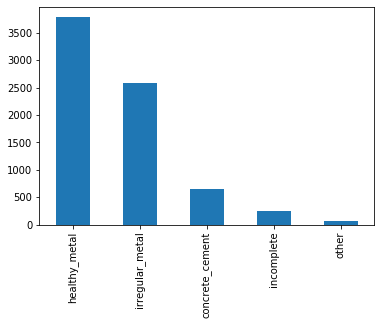

In [75]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")